## Final Project Submission

Please fill out:
* Student name: Rachel Beery
* Student pace: Full time
* Scheduled project review date/time: 9/21/2020 5:00 P.M.
* Instructor name: James
* Blog post URL:


### Need to inser Image

# Module 2 Final Project: King County Housing Authority 

**Objective:** In this project we will be finding the best model for interpretability so that our non-technical audience can understand the findings of our modeling. 

**Approach:** The OSEUMiN data science workflow is utilized to effectively create a model to find what factors can result in the most profitable house.

**Data:** The data used for this project was records of houses sold in King County Washington. The columns of data provided include:

* **id** - unique identifier for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zip code** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

**Audience:** Non-technical audience of homeowners within King County, Washington who are interested to know what they can do to improve their home to maximize the selling price of their homes.

Questions we will be answering in this notebook:

* What features of a house yield make the house sell at a higher price?

* What effect does outliers have on our outcomes and overall data?

* How will multicollinearity affect what feature yields the highest selling price?

* 

# Importing Packages & Our Data

In [67]:
#We begin by importing all the packages we will need to read and clean the datasets, analyze the data, and finally make visualizations 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import math
import scipy.stats as stats
import missingno as ms
#for feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
linreg = LinearRegression()

In [2]:
# Setting the display defaults
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', None)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Import data and see the headers
house_data = pd.read_csv(r"kc_house_data.csv")
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,nan,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


In [4]:
# How many houses are in our dataset
house_data.shape

(21597, 21)

In [5]:
# Looking at our columns and seeing what data types they are
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


# Scrub

First we will address the target: price of house

In [6]:
# Changing dtypes that we know is numbers
house_data.price = house_data.price.astype('int64')

In [7]:
house_data.price.describe()

count     21597.000
mean     540296.574
std      367368.140
min       78000.000
25%      322000.000
50%      450000.000
75%      645000.000
max     7700000.000
Name: price, dtype: float64

In [8]:
# Looking at all the object columns and seeing the unique values in each
objects = house_data.select_dtypes(include='object')
house_data.nunique()

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

In [9]:
# Finding out where null values are in DF
nulls = house_data.isna().sum()
only_nulls = nulls[nulls>0]/len(house_data)
only_nulls.to_frame('Percent Null').style.background_gradient(cmap='Reds')
# Waterfront and Year_renovated are only significant

,Percent Null
waterfront,0.110015
view,0.00291707
yr_renovated,0.177895


In [10]:
null_cols = list(only_nulls.index)
null_cols

['waterfront', 'view', 'yr_renovated']

In [11]:
house_data[null_cols].mode()

,waterfront,view,yr_renovated
0,0.000,0.000,0.000


In [12]:
house_data[null_cols].nunique()

waterfront       2
view             5
yr_renovated    70
dtype: int64

In [13]:
house_data.isna().sum(axis=1).value_counts()

0    15762
1     5391
2      442
3        2
dtype: int64

In [14]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


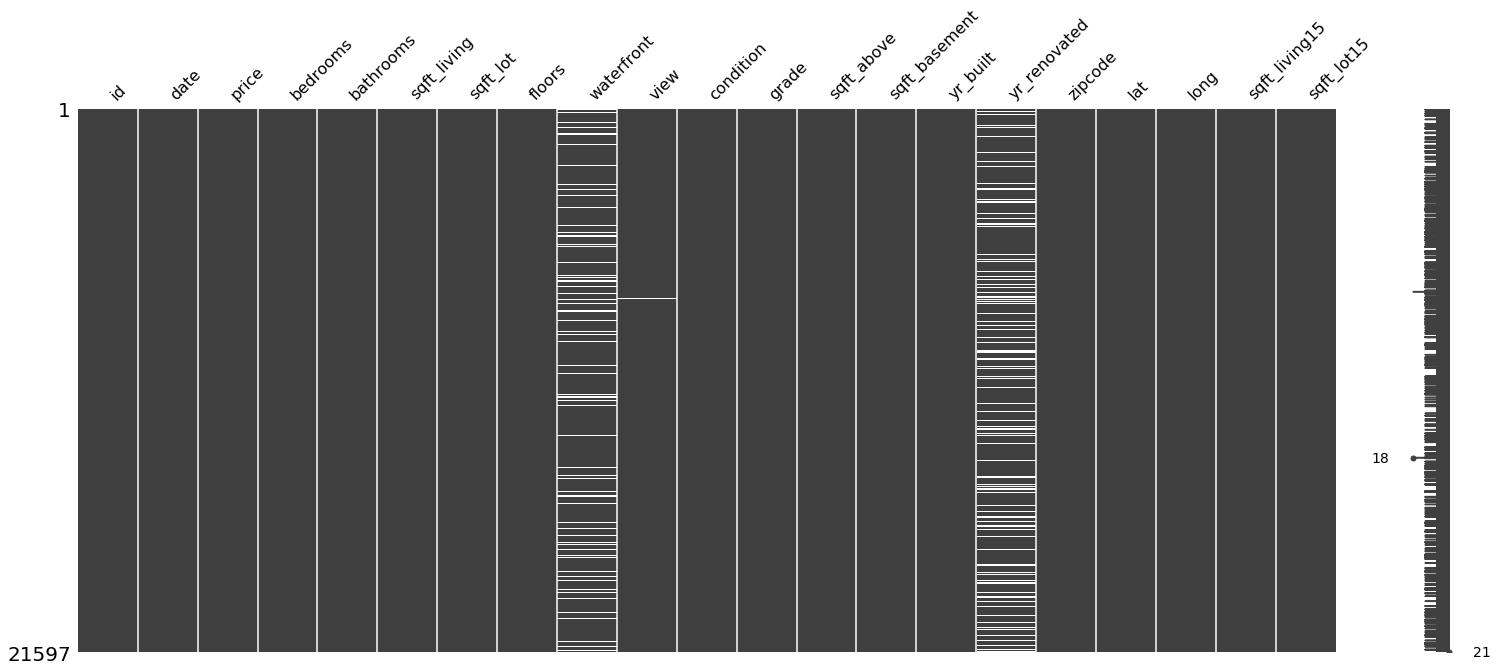

In [15]:
# Seeing if there is a pattern in specific houses that having nulls
import missingno as ms
ms.matrix(house_data)

In [16]:
### cat_cols = house_data.select_dt

In [17]:
### num_cols = house_data.select_dtypes('number').columns
### num_cols

In [18]:
# What columns have null values
house_data.isna().sum()
# We still have nulls in waterfront, view, and sqft_basement
# Going to these sections in the notebook to fix these columns

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [19]:
# Fix sqft of basement first
house_data['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
300.0       142
900.0       142
200.0       105
750.0       104
530.0       103
450.0       103
480.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
860.0        79
670.0        78
1100.0       78
780.0        76
550.0        76
650.0        75
240.0        74
380.0        73
680.0        73
360.0        72
850.0        72
910.0        71
940.0        71
770.0        71
440.0        69
880.0        69
290.0        69
1200.0       69
520.0        68
350.0        68
920.0        66
630.0        66
730.0        65
960.0        65
430.0        64
740.0        64
1010.0       63
760.0        63
640.0        63
560.0        62
570.0        62
340.0        62
280.0        62
950.0        62
820.0        62
460.0        61
790.0        61
310.0        58
1060.0       58
980.0        57
830.0        56
540.0        55
810.0   

In [20]:
# Fixing the '?'
house_data['sqft_basement'].replace('?', np.nan, inplace = True) 
# Changing the dtype to float instead of string
house_data['sqft_basement'] = house_data['sqft_basement'].astype('float')

In [21]:
house_data['sqft_basement'].replace('?', '0')

0          0.000
1        400.000
2          0.000
3        910.000
4          0.000
5       1530.000
6            nan
7          0.000
8        730.000
9          0.000
10      1700.000
11       300.000
12         0.000
13         0.000
14         0.000
15       970.000
16         0.000
17         0.000
18           nan
19         0.000
20       760.000
21       720.000
22         0.000
23         0.000
24         0.000
25         0.000
26       700.000
27         0.000
28       730.000
29         0.000
30         0.000
31         0.000
32       820.000
33         0.000
34       780.000
35       790.000
36       730.000
37         0.000
38       330.000
39         0.000
40         0.000
41      1620.000
42           nan
43         0.000
44       360.000
45         0.000
46         0.000
47         0.000
48         0.000
49       588.000
50         0.000
51      1510.000
52       410.000
53       990.000
54       600.000
55         0.000
56         0.000
57         0.000
58         0.0

In [22]:
house_data['sqft_basement'].nunique()

303

In [23]:
# Nulls will be changed to the mode of 0.0 for basement sqft 
house_data['sqft_basement'].mode()
house_data['sqft_basement'].fillna(0.0, axis = 0, inplace = True)

In [24]:
# Changing 'sqft_basement' to int64
house_data.sqft_basement = house_data.sqft_basement.astype('int64')

In [25]:
### Data type is an object and needs to be changed to int64
house_data['date'].value_counts()

6/23/2014     142
6/26/2014     131
6/25/2014     131
7/8/2014      127
4/27/2015     126
3/25/2015     123
4/14/2015     121
4/22/2015     121
4/28/2015     121
7/9/2014      121
6/24/2014     119
4/21/2015     119
10/28/2014    117
8/26/2014     117
7/14/2014     116
5/20/2014     116
7/1/2014      115
8/20/2014     114
6/17/2014     113
4/29/2015     113
7/29/2014     112
4/8/2015      112
5/28/2014     111
7/16/2014     111
4/23/2015     110
8/25/2014     109
8/5/2014      109
3/27/2015     109
8/11/2014     107
6/20/2014     107
7/23/2014     107
3/26/2015     105
7/22/2014     105
6/3/2014      104
5/27/2014     104
4/2/2015      103
9/23/2014     103
8/22/2014     103
4/24/2015     103
7/15/2014     102
7/25/2014     102
8/27/2014     102
4/7/2015      102
5/4/2015      102
6/19/2014     101
3/24/2015     101
8/12/2014     100
7/18/2014     100
6/4/2014      100
3/4/2015      100
11/13/2014    100
6/18/2014      99
9/24/2014      99
2/24/2015      98
6/10/2014      98
8/13/2014 

In [26]:
# Changing the date column into a datetime
house_data['date'] = pd.to_datetime(house_data['date'])
# Making a new column for year
house_data['year'] = house_data['date'].dt.year
# Making a new column for month
house_data['month'] = house_data['date'].dt.month 
# Making a new column for day
house_data['day'] = house_data['date'].dt.dayofweek

In [27]:
house_data.drop(['date'], axis = 1, inplace = True)

In [28]:
# Looking to see the days of the week
house_data['day'].value_counts()

1    4710
2    4600
0    4097
3    3989
4    3684
5     287
6     230
Name: day, dtype: int64

In [29]:
# Changing the year column
type(house_data['year'][1])

numpy.int64

In [30]:
# Making a column for how old the house is
house_data['house_age'] = house_data['year'] - house_data['yr_built']

In [31]:
house_data.drop(['year', 'yr_built'], axis = 1, inplace = True)
house_data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,house_age
0,7129300520,221900,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0,0.000,98178,47.511,-122.257,1340,5650,10,0,59
1,6414100192,538000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400,1991.000,98125,47.721,-122.319,1690,7639,12,1,63
2,5631500400,180000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0,nan,98028,47.738,-122.233,2720,8062,2,2,82
3,2487200875,604000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910,0.000,98136,47.521,-122.393,1360,5000,12,1,49
4,1954400510,510000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0,0.000,98074,47.617,-122.045,1800,7503,2,2,28


In [32]:
# Removing null values and changing the data type to integer
house_data['yr_renovated'].mode()
house_data['yr_renovated'].fillna(0.0, axis = 0, inplace = True)
house_data['yr_renovated'] = house_data['yr_renovated'].astype('int')
house_data['yr_renovated'].value_counts()

0       20853
2014       73
2003       31
2013       31
2007       30
2005       29
2000       29
2004       22
1990       22
2009       21
2006       20
1989       20
2002       17
1998       16
1984       16
1991       16
1999       15
2008       15
2010       15
2001       15
1983       15
1986       14
1985       14
1987       14
2015       14
1994       14
1992       13
1995       12
1993       12
1997       12
1996       11
1988       11
1970        9
2011        9
1980        8
2012        8
1982        8
1979        7
1977        7
1968        7
1975        5
1964        5
1963        4
1969        4
1981        4
1965        4
1973        4
1955        3
1956        3
1972        3
1978        3
1960        3
1958        3
1945        3
1962        2
1967        2
1957        2
1974        2
1940        2
1948        1
1959        1
1934        1
1971        1
1954        1
1950        1
1976        1
1953        1
1951        1
1946        1
1944        1
Name: yr_renovated, 

In [33]:
# There are many houses that dont have renovation
# Will make these Booleans with this function below

for i in house_data['yr_renovated']:
    if i > 0:
        house_data['yr_renovated'].replace(i, 1, inplace = True)

# Change column name
house_data['was_renovated'] = house_data['yr_renovated']
house_data.drop(['yr_renovated'], axis = 1, inplace = True)

print(house_data['was_renovated'].value_counts())
house_data.head()

0    20853
1      744
Name: was_renovated, dtype: int64


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,house_age,was_renovated
0,7129300520,221900,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0,98178,47.511,-122.257,1340,5650,10,0,59,0
1,6414100192,538000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400,98125,47.721,-122.319,1690,7639,12,1,63,1
2,5631500400,180000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0,98028,47.738,-122.233,2720,8062,2,2,82,0
3,2487200875,604000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910,98136,47.521,-122.393,1360,5000,12,1,49,0
4,1954400510,510000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0,98074,47.617,-122.045,1800,7503,2,2,28,0


In [34]:
# Is there anymore we need to fix befor outlier removal?
house_data.head()
house_data.isna().sum()

id                  0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
month               0
day                 0
house_age           0
was_renovated       0
dtype: int64

In [35]:
# Nulls will be changed to the mode of 0.0 for waterfront 
house_data['waterfront'].mode()
house_data['waterfront'].fillna(0.0, axis = 0, inplace = True)
# Changing the data type to integer
house_data['waterfront'] = house_data['waterfront'].astype(int)

In [36]:
# Nulls will be changed to the mode of 0.0 for viewed 
house_data['view'].mode()
house_data['view'].fillna(0.0, axis = 0, inplace = True)
# Changing the data type to integer
house_data['view'] = house_data['view'].astype(int)

In [37]:
house_data.isna().sum()
# Yay, there are no more null values

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
month            0
day              0
house_age        0
was_renovated    0
dtype: int64

In [38]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
id               21597 non-null int64
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int32
view             21597 non-null int32
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
month            21597 non-null int64
day              21597 non-null int64
house_age        21597 non-null int64
was_renovated    21597 non-null int32
dtypes: float64(4), int32(3), int64(15)
memory 

In [39]:
# Going to go ahead and drop 'id', 'waterfront', & 'view' 
# because these are either irrelevent or cannot be changed by the homeowner
house_data.drop(['id'], axis = 1, inplace = True)
house_data.drop(['waterfront'], axis = 1, inplace = True)
house_data.drop(['view'], axis = 1, inplace = True)
house_data.drop(['day'], axis = 1, inplace = True)

In [40]:
house_data.month.value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month, dtype: int64

In [41]:
# Making seasons to see what time of year might have the highest selling points
def seasons(x):
    if x > 0 and x < 4:
        season = 1
    elif x > 3 and x < 7:
        season = 2
    elif x > 6 and x < 10:
        season = 3
    else:
        season = 4       
    return season

In [42]:
house_data['seasons'] = house_data['month'].map(seasons)

In [43]:
house_data.seasons.value_counts()
# The best = Season 2
# The worst = Season 1

2    6821
3    5921
4    4755
1    4100
Name: seasons, dtype: int64

In [44]:
house_data['has_basement'] = house_data['sqft_basement'].map(lambda x: x!=0 )

In [45]:
house_data['has_basement'] = house_data['has_basement'].astype('int64')

In [46]:
house_data.has_basement.value_counts()

0    13280
1     8317
Name: has_basement, dtype: int64

# Exploring

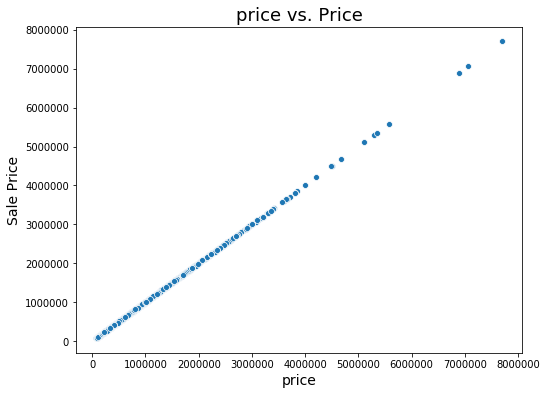

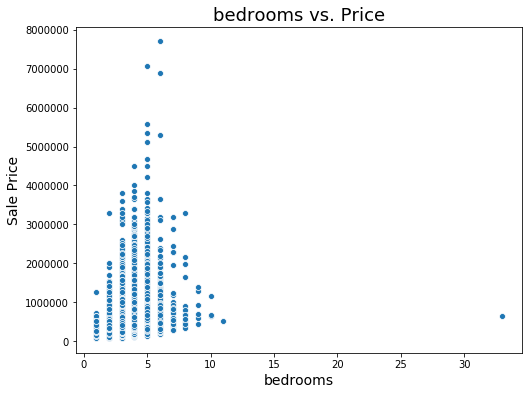

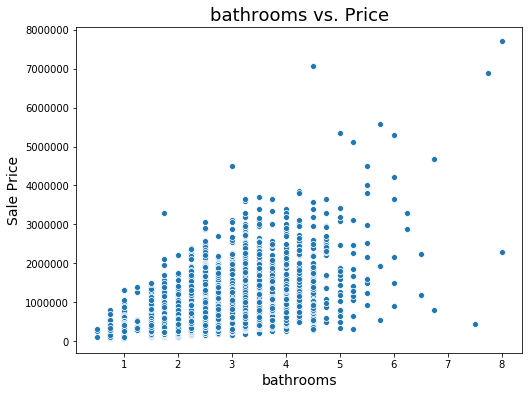

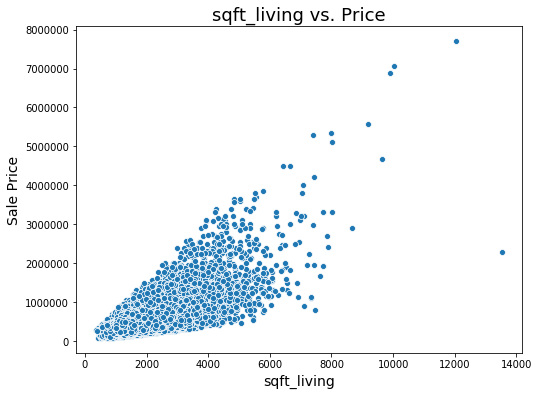

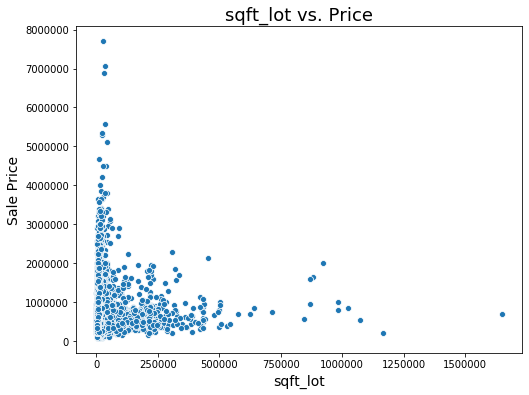

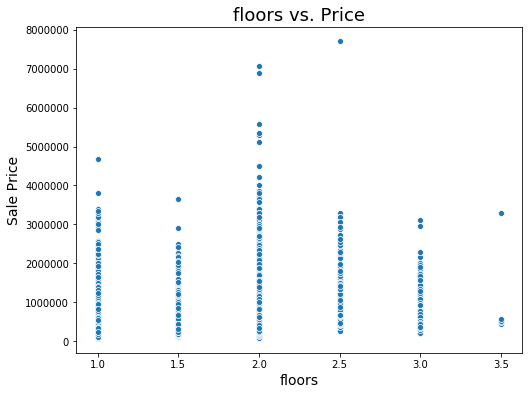

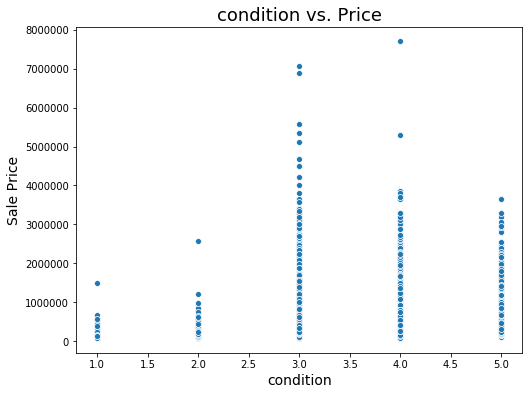

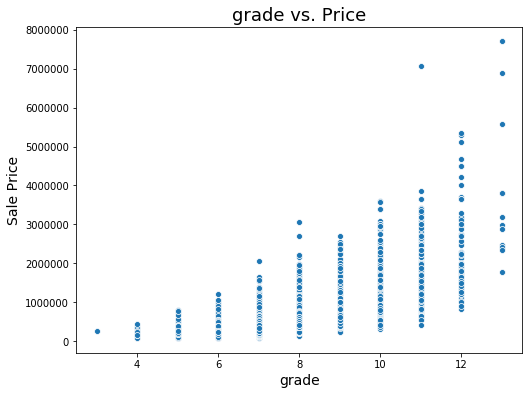

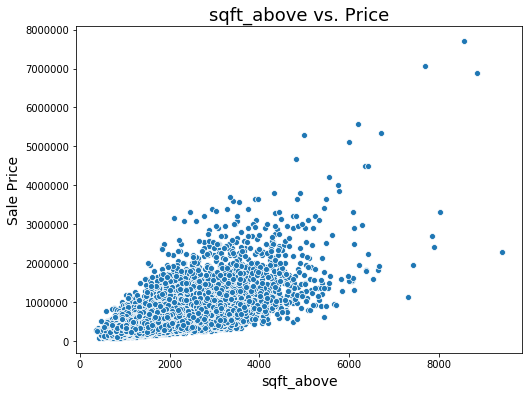

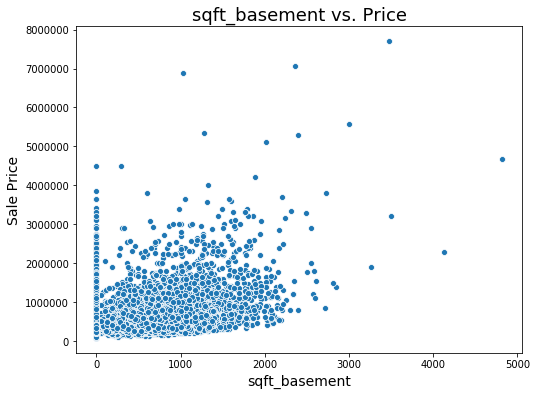

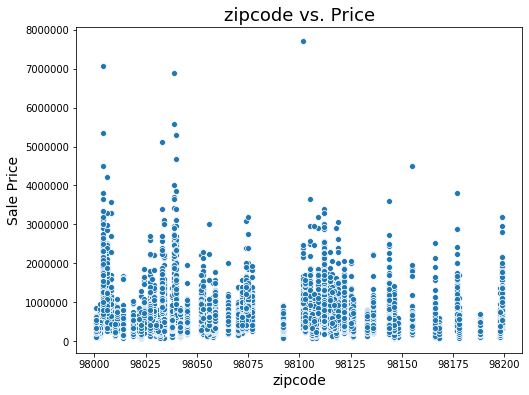

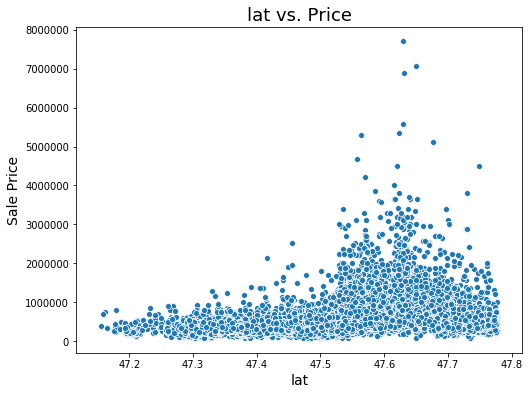

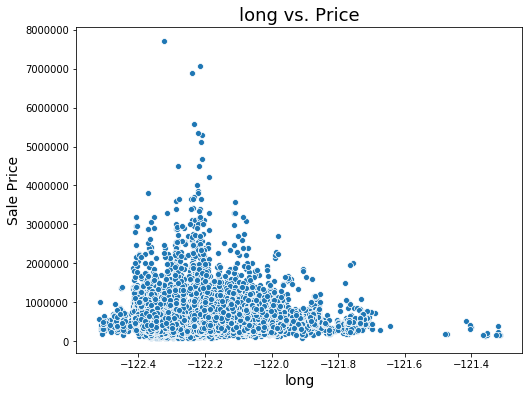

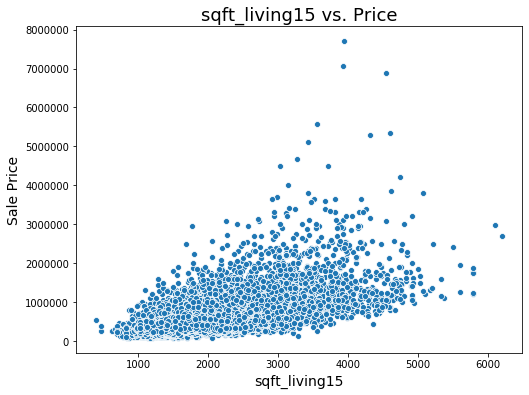

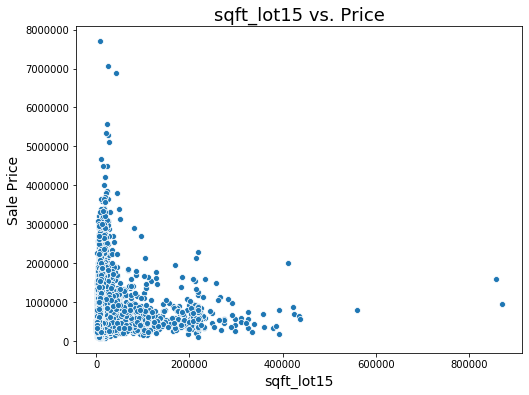

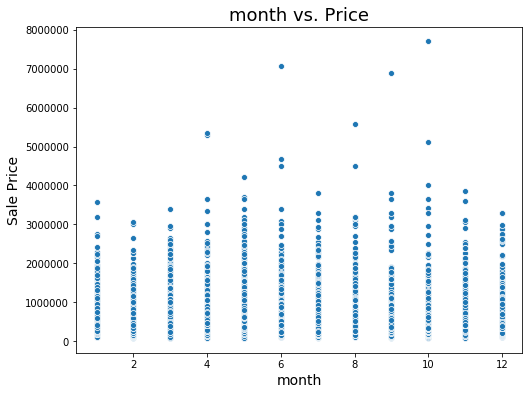

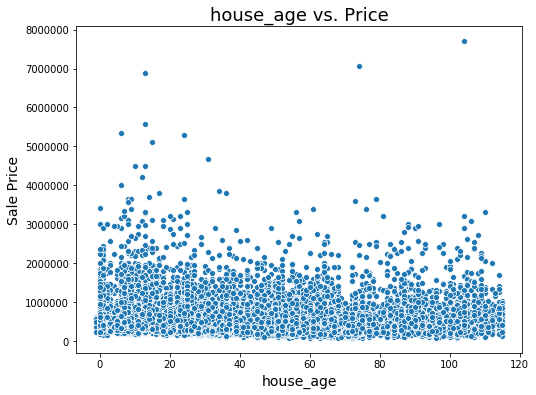

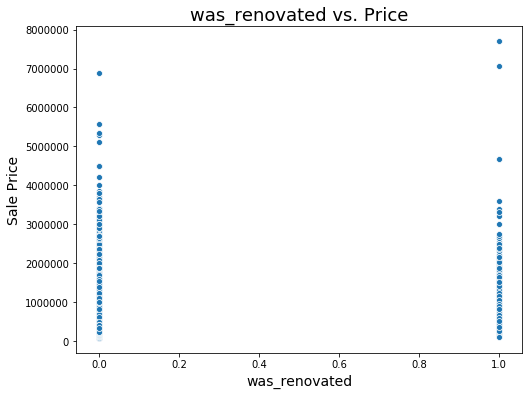

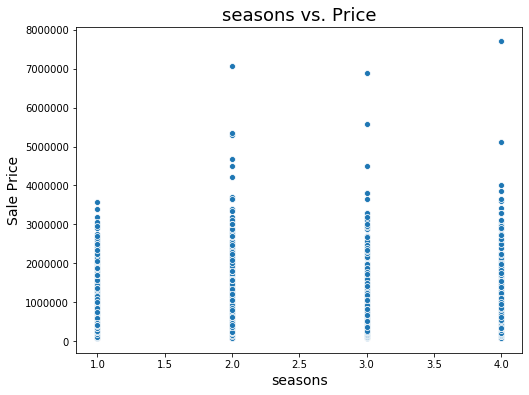

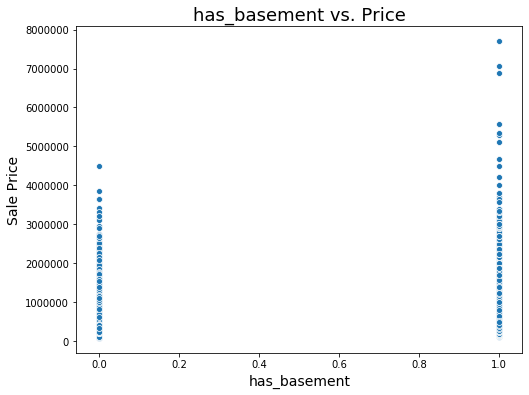

In [47]:
# A good method to understand the spread of each variable is through plotting

# Creating a function to make scatter plots
def scatterplot(col):
    ax = plt.figure(figsize = (8,6))
    ax = sns.scatterplot(x = house_data[col], y = house_data['price'])
    ax.set_title('{} vs. Price'.format(col), fontsize = 18)
    ax.set_xlabel('{}'.format(col), fontsize = 14)
    ax.set_ylabel('Sale Price', fontsize = 14);

for col in house_data:

    scatterplot(col)

In [48]:
# Defining the features that might work better as categories
house_data['condition'] = house_data['condition'].astype('category')
house_data['zipcode'] = house_data['zipcode'].astype('category')
house_data['month'] = house_data['month'].astype('category')
house_data['seasons'] = house_data['seasons'].astype('category')
house_data['month'] = house_data['month'].astype('category')

In [49]:
# Defining what is categories
# categories = ['condition', 'zipcode', 'month', 'seasons', 'month']
# for col in categories:
  #  house_data[col] = house_data.astype('category')

In [50]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
condition        21597 non-null category
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
zipcode          21597 non-null category
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
month            21597 non-null category
house_age        21597 non-null int64
was_renovated    21597 non-null int32
seasons          21597 non-null category
has_basement     21597 non-null int64
dtypes: category(4), float64(4), int32(1), int64(11)
memory usage: 2.6 MB


In [51]:
# Plotting Price with the categories:
def categorical_plots(df):
    for col in df.select_dtypes('category'):
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=col, y='price', data=df, palette="colorblind")
        ax.set_title(f"{col} vs Price", fontsize=30)
        plt.xticks(rotation=45)
        plt.show()

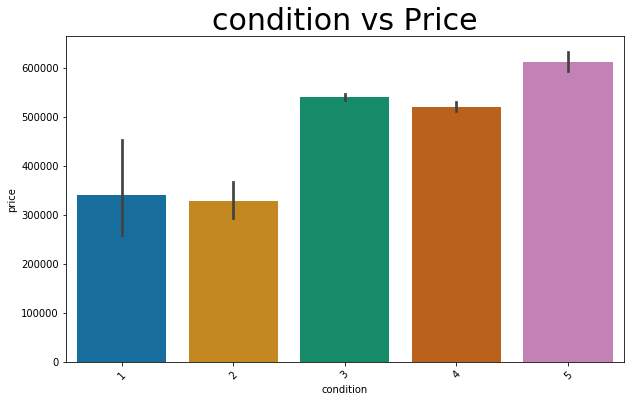

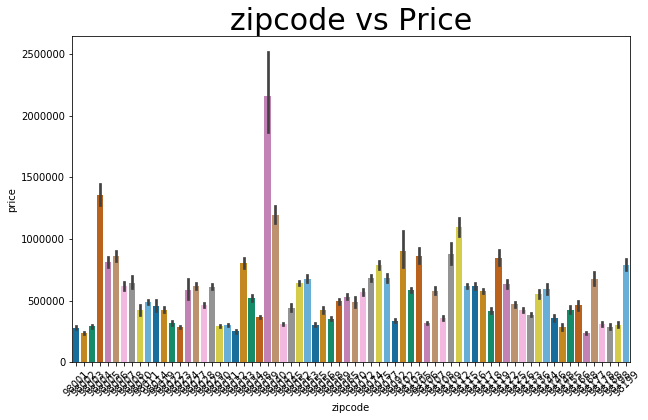

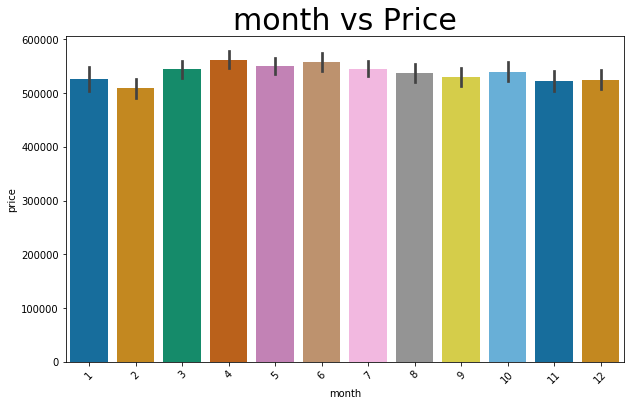

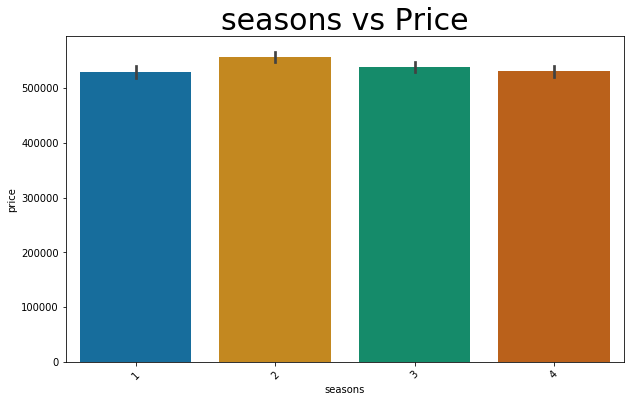

In [52]:
categorical_plots(house_data)

# Multicolinearity

In [53]:
# We will be dropping zipcode, lat, and long from this model as they have to do with location
# which the homeowner cannot change
df1 = house_data.copy()
df1.drop(columns=['lat', 'long', 'zipcode'], inplace=True)

In [54]:
df1.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,month,house_age,was_renovated,seasons,has_basement
0,221900,3,1.000,1180,5650,1.000,3,7,1180,0,1340,5650,10,59,0,4,0
1,538000,3,2.250,2570,7242,2.000,3,7,2170,400,1690,7639,12,63,1,4,1
2,180000,2,1.000,770,10000,1.000,3,6,770,0,2720,8062,2,82,0,1,0
3,604000,4,3.000,1960,5000,1.000,5,7,1050,910,1360,5000,12,49,0,4,1
4,510000,3,2.000,1680,8080,1.000,3,8,1680,0,1800,7503,2,28,0,1,0


In [55]:
# Checking for correlation in features before we go to remove outliers
corr1 = df1.iloc[:,2:] 
corr1.corr().abs().style.background_gradient(cmap='coolwarm')

,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,house_age,was_renovated,has_basement
bathrooms,1,0.755758,0.0883727,0.502582,0.665838,0.686668,0.278485,0.569884,0.0883025,0.507561,0.0467422,0.159863
sqft_living,0.755758,1,0.173453,0.353953,0.762779,0.876448,0.42866,0.756402,0.184342,0.318592,0.0508293,0.201198
sqft_lot,0.0883727,0.173453,1,0.00481436,0.114731,0.184139,0.0150311,0.144763,0.718204,0.052853,0.00509086,0.0348888
floors,0.502582,0.353953,0.00481436,1,0.458794,0.523989,0.241866,0.280102,0.0107217,0.489514,0.00371281,0.252465
grade,0.665838,0.762779,0.114731,0.458794,1,0.756073,0.165843,0.713867,0.120981,0.448322,0.0152589,0.0507011
sqft_above,0.686668,0.876448,0.184139,0.523989,0.756073,1,0.0511751,0.731767,0.195077,0.424386,0.0205655,0.207268
sqft_basement,0.278485,0.42866,0.0150311,0.241866,0.165843,0.0511751,1,0.199288,0.015885,0.129837,0.0646745,0.820893
sqft_living15,0.569884,0.756402,0.144763,0.280102,0.713867,0.731767,0.199288,1,0.183515,0.326697,0.000622269,0.0445768
sqft_lot15,0.0883025,0.184342,0.718204,0.0107217,0.120981,0.195077,0.015885,0.183515,1,0.0707697,0.00438033,0.0417474
house_age,0.507561,0.318592,0.052853,0.489514,0.448322,0.424386,0.129837,0.326697,0.0707697,1,0.20251,0.16388


(14, -0.5)

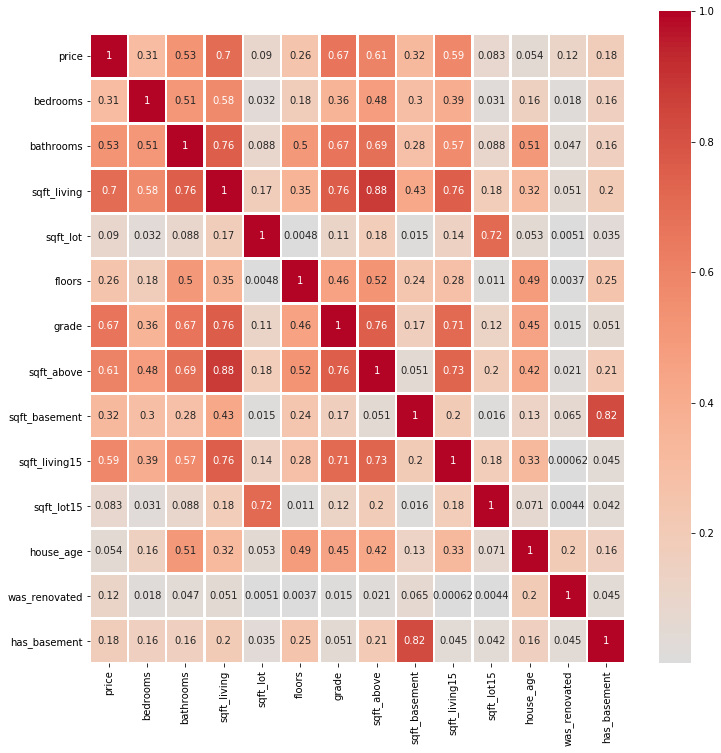

In [56]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df1.corr().abs(), center=0, annot=True, linewidths=1.5, cmap='coolwarm');
ax.set_ylim(len(df1.corr())-0, -0.5)

**To note:
There are some features that have high correlation that will need to be addressed later on**
    

# One Hot Encoding 

In [57]:
# Now that we understand the data better,
# Let's seperate and specify the numerical and categorical data 
# This will allow us to one hot encode it
numerical = [col for col in house_data.columns if house_data[col].dtype == 'object']
categorical = [col for col in house_data.columns if house_data[col].dtype != 'object']

print(categorical)
print(numerical)

['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'house_age', 'was_renovated', 'seasons', 'has_basement']
[]


In [58]:
# One Hot Encoding
df_dummies = house_data.copy()
df_dummies = pd.get_dummies(house_data, columns = categorical, drop_first = True)
print(df_dummies.shape)
df_dummies.head()

(21597, 31170)


,price_80000,price_81000,price_82000,price_82500,price_83000,price_84000,price_85000,price_86500,price_89000,price_89950,price_90000,price_92000,price_95000,price_96500,price_99000,price_100000,price_102500,price_104950,price_105000,price_105500,price_106000,price_107000,price_109000,price_109500,price_110000,price_110700,price_111300,price_112000,price_114000,price_114975,price_115000,price_118000,price_118125,price_119500,price_119900,price_120000,price_120750,price_121800,price_122000,price_123000,...,house_age_81,house_age_82,house_age_83,house_age_84,house_age_85,house_age_86,house_age_87,house_age_88,house_age_89,house_age_90,house_age_91,house_age_92,house_age_93,house_age_94,house_age_95,house_age_96,house_age_97,house_age_98,house_age_99,house_age_100,house_age_101,house_age_102,house_age_103,house_age_104,house_age_105,house_age_106,house_age_107,house_age_108,house_age_109,house_age_110,house_age_111,house_age_112,house_age_113,house_age_114,house_age_115,was_renovated_1,seasons_2,seasons_3,seasons_4,has_basement_1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modeling before Addressing Outliers

In [59]:
features = '+'.join(house_data.drop('price', axis = 1).columns)
formula = 'price ~' + features
model1 = smf.ols(formula, house_data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     716.3
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        21:58:30   Log-Likelihood:            -2.9164e+05
No. Observations:               21597   AIC:                         5.835e+05
Df Residuals:                   21497   BIC:                         5.843e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.247e+07   6.79e+06     -4.786      0.000   -4.58e+07   -1.92e+07
condition[T.2]    2.707e+04   3.58e+04      0.756      0.450   -4.31e+04    9.73e+04
condition[T.3]    1.563e+04   3.33e+04      0.470      0.638   -4.96e+04    8.08e+04
condition[T.4]    3.862e+04   3.33e+04      1.161      0.246   -2.66e+04    1.04e+05
condition[T.5]     8.03e+04   3.35e+04      2.399      0.016    1.47e+04    1.46e+05
zipcode[T.98002]  4.565e+04    1.6e+04      2.853      0.004    1.43e+04     7.7e+04
zipcode[T.98003] -2.457e+04   1.43e+04     -1.718      0.086   -5.26e+04    3462.435
zipcode[T.98004]  7.462e+05    2.6e+04     28.701      0.000    6.95e+05    7.97e+05
zipcode[T.98005]   2.75e+05   2.78e+04      9.898      0.000    2.21e+05     3.3e+05
zipcode[T.98006]  2.707e+05   2.27e+04     11.917      0.000    2.26e+05    3.15e+05
zipcode[T.98007]    2.4e+05   2.87e+04      8.369      0.000    1.84e+05    2.96e+05
zipcode[T.98008]  3.002e+05   2.72e+04     11.037      0.000    2.47e+05    3.54e+05
zipcode[T.98010]  1.225e+05   2.44e+04      5.024      0.000    7.47e+04     1.7e+05
zipcode[T.98011]  1.017e+05   3.54e+04      2.872      0.004    3.23e+04    1.71e+05
zipcode[T.98014]  1.831e+05   3.89e+04      4.708      0.000    1.07e+05    2.59e+05
zipcode[T.98019]  1.354e+05   3.84e+04      3.530      0.000    6.02e+04    2.11e+05
zipcode[T.98022]  8.221e+04   2.12e+04      3.883      0.000    4.07e+04    1.24e+05
zipcode[T.98023] -5.542e+04   1.32e+04     -4.211      0.000   -8.12e+04   -2.96e+04
zipcode[T.98024]  2.226e+05   3.42e+04      6.502      0.000    1.55e+05     2.9e+05
zipcode[T.98027]  1.957e+05   2.33e+04      8.392      0.000     1.5e+05    2.41e+05
zipcode[T.98028]  9.717e+04   3.44e+04      2.825      0.005    2.97e+04    1.65e+05
zipcode[T.98029]  2.444e+05   2.66e+04      9.181      0.000    1.92e+05    2.97e+05
zipcode[T.98030]  1.556e+04   1.57e+04      0.989      0.322   -1.53e+04    4.64e+04
zipcode[T.98031]  2.371e+04   1.64e+04      1.447      0.148   -8402.873    5.58e+04
zipcode[T.98032]  2586.4567    1.9e+04      0.136      0.892   -3.47e+04    3.99e+04
zipcode[T.98033]  3.606e+05   2.95e+04     12.219      0.000    3.03e+05    4.18e+05
zipcode[T.98034]  2.058e+05   3.16e+04      6.505      0.000    1.44e+05    2.68e+05
zipcode[T.98038]  7.599e+04   1.77e+04      4.304      0.000    4.14e+04    1.11e+05
zipcode[T.98039]  1.273e+06   3.51e+04     36.245      0.000     1.2e+06    1.34e+06
zipcode[T.98040]  5.142e+05    2.3e+04     22.367      0.000    4.69e+05    5.59e+05
zipcode[T.98042]  3.174e+04    1.5e+04      2.109      0.035    2239.308    6.12e+04
zipcode[T.98045]  2.115e+05   3.26e+04      6.487      0.000    1.48e+05    2.75e+05
zipcode[T.98052]   2.29e+05   3.01e+04      7.601      0.000     1.7e+05    2.88e+05
zipcode[T.98053]  2.089

This already tells us a lot about our initial data. To start we can see that our r-squared value is 0.767 which is very high. The 'Skew' value is 4.919, showing that the data has outliers that need to be addressed. The 'Kurtosis' value is 70.740, also showing heavy tails. Warnings also tell us that there may be issues with strong multicolinearity.

In [60]:
model1.resid.mean()

1.9887647772517563e-06

<Figure size 864x432 with 0 Axes>

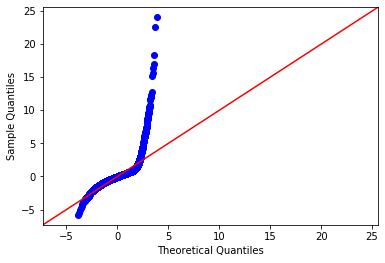

In [61]:
# QQ plot to see if our data is linear
fig1 = plt.figure(figsize = (12,6))
fig1 = sm.graphics.qqplot(model1.resid,fit=True, line='45');

Wow, that's a really bad QQ plot result. Removing outliers will hopefully fix this issue

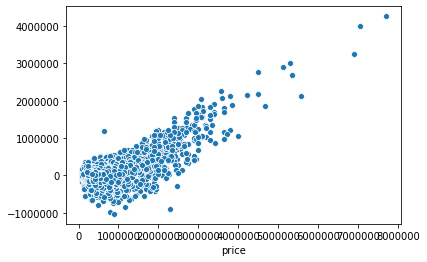

In [62]:
# I have a feeling that this scatterplot will show our data is heteroscadastic
# But for good measure will go ahead and make it
sns.scatterplot(house_data['price'], model1.resid, );

This visual clearly shows that we have some outliers in price. Now we will move on to remove them and see the difference.

In [68]:
# Creating a function to make models in the rest of this notebook
# This function includes:
# Running diagnostics
# Making a train test split
# Plotting the qq plot of residuals in order to see normality
# Plot for homoscedasticity check of residuals
# Plotting a scatterplot of the predicted vs actual test data prices 
# to visually inspect how different they are
# Creating a plot of the first 100 entries of predicted vs actual prices
# Generating the r2 to compare test vs actual

def make_model(df, target='price', test_size=0.25, cv=20):
    X = df.drop([target], axis=1)
    y = df[[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=123)
    df_train = pd.concat([y_train, X_train], axis=1)
    df_test = pd.concat([y_test, X_test], axis=1)
    cat_cols = df_train.select_dtypes('category').columns
    features = '+'.join(df_train.drop(columns=target).columns)
    for col in cat_cols:
        features = features.replace(col,f'C({col})') 
    formula = target + '~' + features
    model = smf.ols(formula, df_train).fit()
    fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
    sm.graphics.qqplot(model.resid, fit=True, line='45', ax=axes[0])
    axes[0].set_title('QQ Plot Normality Check', fontsize=20)
    ax=axes[1]
    ax.scatter(df_train['price'], model.resid)
    ax.axhline(0, color='purple')
    axes[1].set_title('Homoscedasticity', fontsize=20)
    plt.show();
    y_predicted = model.predict(X_test)
    plt.figure(figsize=(20,5))   
    
    g = sns.scatterplot(range(len(y_predicted[:200])), y_predicted[:200], 
                        label='Predicted Prices')
    g = sns.scatterplot(range(len(y_test[:200])), y_test.price[:200], 
                        label='Actual Prices')
    plt.title('Comparison of predicted vs actual price', 
              fontdict={'fontsize':20})
    plt.xlabel('Values')
    plt.ylabel('Prices')
    plt.legend()
    plt.show();
    
    r2_test = r2_score(y_test, y_predicted)
    print('Model test data R2 score:', r2_test)
    cv_result = np.mean(cross_val_score(linreg, X, y, cv=cv, 
                                        scoring='neg_mean_squared_error'))
    print('K-fold cross validation negative MSE:', cv_result)
    display(model.summary())
    return model

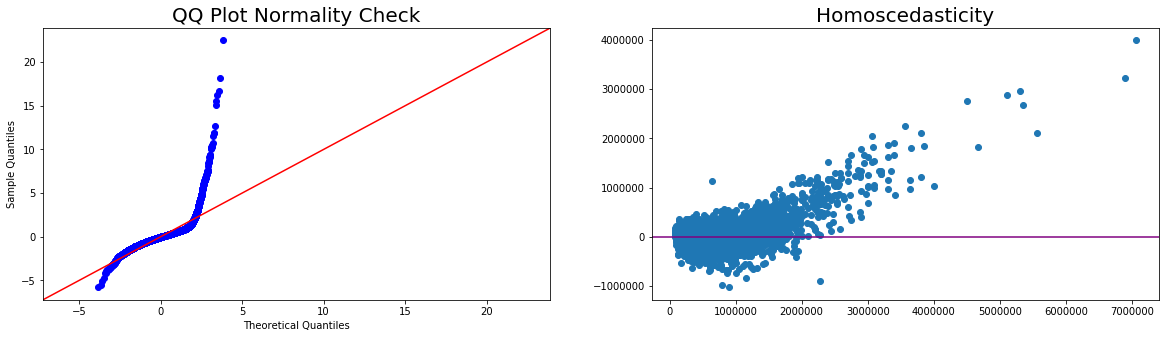

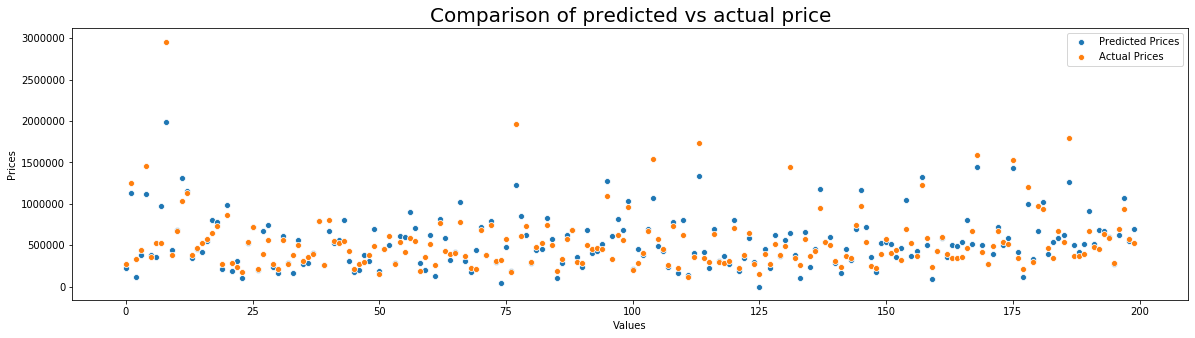

Model test data R2 score: 0.7651122332611704
K-fold cross validation negative MSE: -45770229268.026505


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     536.5
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:05:54   Log-Likelihood:            -2.1877e+05
No. Observations:               16197   AIC:                         4.377e+05
Df Residuals:                   16097   BIC:                         4.385e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3.283e+07   7.86e+06     -4.176      0.000   -4.82e+07   -1.74e+07
C(condition)[T.2]    2.909e+04   4.01e+04      0.726      0.468   -4.94e+04    1.08e+05
C(condition)[T.3]    1.051e+04   3.67e+04      0.286      0.775   -6.15e+04    8.25e+04
C(condition)[T.4]    3.547e+04   3.67e+04      0.966      0.334   -3.65e+04    1.07e+05
C(condition)[T.5]    7.547e+04    3.7e+04      2.041      0.041    2992.811    1.48e+05
C(zipcode)[T.98002]  4.232e+04   1.85e+04      2.286      0.022    6025.260    7.86e+04
C(zipcode)[T.98003]  -2.76e+04   1.64e+04     -1.687      0.092   -5.97e+04    4467.903
C(zipcode)[T.98004]  7.475e+05   3.01e+04     24.821      0.000    6.88e+05    8.06e+05
C(zipcode)[T.98005]  2.709e+05   3.22e+04      8.410      0.000    2.08e+05    3.34e+05
C(zipcode)[T.98006]  2.625e+05   2.63e+04      9.976      0.000    2.11e+05    3.14e+05
C(zipcode)[T.98007]  2.417e+05   3.28e+04      7.359      0.000    1.77e+05    3.06e+05
C(zipcode)[T.98008]  2.955e+05   3.13e+04      9.453      0.000    2.34e+05    3.57e+05
C(zipcode)[T.98010]  1.204e+05   2.76e+04      4.365      0.000    6.63e+04    1.75e+05
C(zipcode)[T.98011]  9.714e+04    4.1e+04      2.371      0.018    1.68e+04    1.77e+05
C(zipcode)[T.98014]  1.891e+05   4.51e+04      4.189      0.000    1.01e+05    2.78e+05
C(zipcode)[T.98019]  1.328e+05   4.42e+04      3.001      0.003    4.61e+04    2.19e+05
C(zipcode)[T.98022]  7.962e+04   2.45e+04      3.247      0.001    3.16e+04    1.28e+05
C(zipcode)[T.98023] -6.039e+04   1.54e+04     -3.925      0.000   -9.05e+04   -3.02e+04
C(zipcode)[T.98024]  2.067e+05   3.93e+04      5.257      0.000     1.3e+05    2.84e+05
C(zipcode)[T.98027]  1.896e+05    2.7e+04      7.026      0.000    1.37e+05    2.42e+05
C(zipcode)[T.98028]  9.869e+04   3.99e+04      2.473      0.013    2.05e+04    1.77e+05
C(zipcode)[T.98029]  2.431e+05   3.09e+04      7.870      0.000    1.83e+05    3.04e+05
C(zipcode)[T.98030]  5978.6139   1.86e+04      0.321      0.748   -3.05e+04    4.24e+04
C(zipcode)[T.98031]  1.693e+04   1.86e+04      0.912      0.362   -1.94e+04    5.33e+04
C(zipcode)[T.98032]  2463.4769    2.2e+04      0.112      0.911   -4.06e+04    4.55e+04
C(zipcode)[T.98033]  3.654e+05   3.42e+04     10.674      0.000    2.98e+05    4.32e+05
C(zipcode)[T.98034]  2.059e+05   3.66e+04      5.632      0.000    1.34e+05    2.78e+05
C(zipcode)[T.98038]  7.469e+04   2.05e+04      3.649      0.000    3.46e+04    1.15e+05
C(zipcode)[T.98039]  1.279e+06      4e+04     31.951      0.000     1.2e+06    1.36e+06
C(zipcode)[T.98040]  5.346e+05   2.67e+04     19.986      0.000    4.82e+05    5.87e+05
C(zipcode)[T.98042]  3.294e+04   1.74e+04      1.893      0.058   -1158.998     6.7e+04
C(zipcode)[T.98045]  2.133e+05   3.75e+04      5.681      0.000     1.4e+05    2.87e+05
C(z

In [69]:
functionmodel1 = make_model(house_data)

# Log Transformation

In [ ]:
# Function for log transformation
for feat in numerical:
    house_data[feat] = house_data[feat].map(lambda x: np.log(x))

house_data.head()

# Outlier Removal

In [ ]:
# Let's start by making some boxplots to see if there are obvious outliers
for column in house_data.columns:
    plt.figure(figsize = (8,4))
    sns.boxplot(house_data[column])
    plt.title('{}'.format(column))
    plt.show()

In [ ]:
# After researching outlier removal 
# and exploring our data it is best to do IQR type outlier removal methods

def outliersiqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    threshold = iqr * 1.5
    outliers = (data < q1 - threshold) | (data > q3 + threshold)
    outliers = pd.Series(outliers, index=data.index)
    return outliers

In [ ]:
# Function to make an outlier column which we will then remove outliers from
def outlierscolumn(df, columns, verbose=True):
    new_df = df.copy()
    for col in columns:
        outliers = outliersiqr(new_df[col])
        if verbose:
            print(f'{outliers.sum()} outliers found in {col}')
        new_df[f'{col}_outliers'] = outliers
    return new_df

In [ ]:
# Feeding in the numerical columns for identifying outliers
num_cols = list(house_data.select_dtypes('number').columns)

# Saving the new dataframe with outlier columns added
df2 = outlierscolumn(house_data, num_cols)

In [ ]:
df2.head()

In [ ]:
df2.shape

In [ ]:
# Dropping columns that are either continous or boolean (yes or no, has or doesn't have)
# Also removing lat & long (I forgot to remove before)
df2.drop(columns=['was_renovated_outliers', 'lat_outliers', 'long_outliers', 
                        'has_basement_outliers', 'bedrooms_outliers',  
                        'bathrooms_outliers', 'grade_outliers'], inplace=True)

In [ ]:
df2.head()

In [ ]:
# Creating a list of the outlier columns
outliercols = []
for col in df2.columns:
    if 'outliers' in col:
        outliercols.append(col)
outliercols

In [ ]:
# Filtering the outliers out of my dataframe and returning only the entries
# that are not outliers for any of the features
for col in outliercols:
    df2 = df2[(df2[col]==False)]
df2.shape

In [ ]:
# Dropping the outlier columns that were added
for col in outliercols:
    df2.drop(columns=[col], axis=1, inplace=True)

In [ ]:
df2.info()

In [ ]:
df2.describe()

# Linearity, Normality, & Homoscedasticity

In [ ]:
# Let's look at the target price first
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(df2['price'], bins='auto')

# Adjusting the money ticks 
# fmt_money = '${x:,.0f}'


In [ ]:
# Function to make vizuals to show normality
def normalityplots (df, column):
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    df[column].hist(bins = 30)
    plt.subplot(1,2,2)
    stats.probplot(df[column], dist = 'norm', plot = plt)
    plt.title('{}'.format(column))
    plt.show()

# Now let's see the results of the outlier removal
for column in df2.columns:
    normalityplots(df2, column)

In [ ]:
df2.hist(figsize = (14,14));

In [ ]:
# Creating a function that will create a joint plot to vizualize linearity against our target price
def jointplot(df, col, target = 'price'):
    g = sns.jointplot(data = df, x = col, y = target, kind = 'reg')
    plt.suptitle(f"{col} vs. {target}");
    return g

for col in df2.columns:
    jointplot(df2, col)

Our data and feature columns look a bit more normal now. I will need to drop more columns though before I make a new model as they aren't normally distributed or don't make sense for the model and/or I won't be using it for recommendations of how to improve the house.

In [ ]:
df2.drop(columns=['lat', 'long', 'zipcode', 'sqft_lot', 'sqft_lot15', 
                  'sqft_basement'], inplace=True)

In [ ]:
df2.head()

In [ ]:
mfeatures = '+'.join(df2.drop('price', axis = 1).columns)
formula = 'price ~' + features
model2 = smf.ols(formula, house_data).fit()
model2.summary()

Notes:

# Low p-value Removal

In [ ]:
# Function to identify the insignificant p-values
def bad_pvalues(model, verbose=True):
    
#     Pulling out the p-values and identifying the ones above .05
    pvalues = model.pvalues
    bad_features = pvalues[pvalues > .05]
    
#     Excluding the intercept in case it has a high p-value
    if 'Intercept' in bad_features:
        bad_features.remove('Intercept')
        
#      Printing a statement of the bad p-values
    if verbose:
        print(f'{len(bad_features)} bad p-values to be reviewed:\n' 
              + f'{bad_features}')
    return bad_features

In [ ]:
model2_bad_pvals = bad_pvalues(model2)

In [ ]:
# We can see from the low values that month has many low p-value features
# We will be removing zipcode and month
df3 = df2.copy()
df3.drop(columns=(['zipcode', 'month']), inplace=True)
df3.shape

In [ ]:
df3.drop(columns=['sqft_lot'], inplace=True)

In [ ]:
# Model summary to see the changes if significant
mfeatures3 = '+'.join(df3.drop('price', axis = 1).columns)
formula3 = 'price ~' + features
model3 = smf.ols(formula, df3).fit()
model3.summary()

Notes: 

# Multicolinearity Column/Feature Removal

In [ ]:
# Heat Map from above

In [ ]:
sns.heatmap

In [ ]:
df4 = df3.copy()
df4.drop(columns=['',''], inplace=True)

In [ ]:
# Model to see difference

Notes:

# Log Transformation Part 2

# Tableau Map

In [ ]:
# May or May not need this column but making it into an object anyway
newest_df['zipcode'] = newest_df['zipcode'].astype('object') 

# Questions & Answers

# Conclusions

In [ ]:
newest_df.head()

In [ ]:
# Now we will explore multicolinearity
# If changes need to made to individual columns I will make the changes in that section of the notebook